## Kammi

In [1]:
# Import delle librerie necessarie per lo scraping web e la manipolazione dei dati
import requests  # Per eseguire richieste HTTP
from bs4 import BeautifulSoup  # Per analizzare il codice HTML delle pagine web
import pandas as pd  # Per la manipolazione e l'analisi dei dati

# Definizione della funzione che estrae i dettagli dei prodotti dal sito web
def fetch_product_details(base_link, category_link, product_type_link):
    category_data = []  # Lista per raccogliere i dati di ogni categoria di prodotto
    
    # Iterazione su ogni categoria di link fornito
    for category in category_link:
        # Iterazione su ogni tipo di prodotto nella categoria corrente
        for product_type in product_type_link:
            category_url = f"{base_link}{category}{product_type}"  # Costruzione dell'URL per la categoria e il tipo di prodotto
            category_page = requests.get(category_url)  # Richiesta HTTP alla pagina della categoria
            category_soup = BeautifulSoup(category_page.text, "html.parser")  # Analisi della pagina HTML
            
            # Ricerca di tutti i link dei prodotti nella pagina, utilizzando un selettore specifico basato sull'attributo 'onclick'
            product_links = category_soup.find_all("a", onclick=True)
            
            # Iterazione su ogni link di prodotto trovato
            for product_link in product_links:
                product_url = product_link['href']  # Estrazione dell'URL del prodotto
                product_page = requests.get(product_url)  # Richiesta HTTP alla pagina del prodotto
                product_soup = BeautifulSoup(product_page.text, "html.parser")  # Analisi della pagina HTML del prodotto
                
                # Creazione di un dizionario per conservare i dettagli del prodotto corrente
                product_details = {"category": category, "type": product_type}
                
                # Estrazione del nome del prodotto e aggiunta al dizionario dei dettagli
                title_tag = product_soup.find("p", class_="product-title")
                product_details["name"] = title_tag.text.strip() if title_tag else "N/A"
                
                # Estrazione del prezzo del prodotto e aggiunta al dizionario dei dettagli
                price_tag = product_soup.find("p", class_="price mt-2")
                product_details["price"] = price_tag.text.strip() if price_tag else "N/A"
                
                # Ricerca di dettagli aggiuntivi del prodotto nella pagina
                dettagli = product_soup.find_all("p", class_="mt-4")
                
                # Iterazione su ogni elemento di dettaglio trovato per cercare una specifica descrizione
                for dettaglio in dettagli:
                    # Controllo se il dettaglio contiene informazioni specifiche e aggiunta al dizionario dei dettagli del prodotto
                    if "Tacco:" in dettaglio.text and "Materiale esterno:" in dettaglio.text and 'Materiale interno:' in dettaglio.text and 'Materiale suola:' in dettaglio.text:
                        descrizione = dettaglio.text.strip()
                        product_details['description'] = descrizione
                
                # Aggiunta dei dettagli del prodotto corrente alla lista dei dati di categoria
                category_data.append(product_details)
    
    # Ritorno della lista completa dei dati di tutte le categorie e tipi di prodotto
    return category_data

# Definizione degli URL base, delle categorie e dei tipi di prodotto per lo scraping
base_link = "https://www.kammi.it/"
category_link = ["scarpe-donna/"]
product_type_link = ["sneakers/", "sandali-bassi/", "stivali-stivaletti/", "zeppe/", "sandali-con-tacco/", "scarpe-con-tacco/", "scarpe-basse/"]

# Esecuzione della funzione di estrazione dei dettagli dei prodotti e creazione di un DataFrame con i dati ottenuti
product_details = fetch_product_details(base_link, category_link, product_type_link)
kammi_df = pd.DataFrame(product_details)

# Pulizia e formattazione dei dati nel DataFrame
kammi_df['category'] = kammi_df['category'].str.rstrip('/')  # Rimozione del carattere '/' dalla fine dei valori della colonna 'category'
kammi_df['type'] = kammi_df['type'].str.rstrip('/')  # Rimozione del carattere '/' dalla fine dei valori della colonna 'type'
kammi_df['price'] = kammi_df['price'].str.replace('€', '').str.replace(',', '.').astype(float)  # Conversione del prezzo in un formato numerico

# Definizione della funzione per separare le specifiche di descrizione in dettagli chiave-valore
def separa_descrizione(specifiche):
    dettagli = {}
    parti = specifiche.split('\n')  # Divisione della descrizione in parti basate su nuove righe
    for parte in parti:
        chiave_valore = parte.split(':')  # Divisione di ogni parte in chiave e valore
        if len(chiave_valore) == 2:
            chiave, valore = chiave_valore
            chiave = chiave.strip()  # Rimozione degli spazi bianchi dalla chiave
            valore = valore.strip()  # Rimozione degli spazi bianchi dal valore
            dettagli[chiave] = valore  # Aggiunta del dettaglio al dizionario
    return dettagli

# Applicazione della funzione di separazione delle descrizioni e estrazione di dettagli specifici in nuove colonne del DataFrame
descrizioni_dettagliate = kammi_df['description'].apply(separa_descrizione)
kammi_df['Tacco'] = descrizioni_dettagliate.apply(lambda x: x.get('Tacco', 'N/A'))  # Estrazione del dettaglio 'Tacco'
kammi_df['Materiale esterno'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale esterno', 'N/A'))  # Estrazione del dettaglio 'Materiale esterno'
kammi_df['Materiale interno'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale interno', 'N/A'))  # Estrazione del dettaglio 'Materiale interno'
kammi_df['Materiale suola'] = descrizioni_dettagliate.apply(lambda x: x.get('Materiale suola', 'N/A'))  # Estrazione del dettaglio 'Materiale suola'
kammi_df = kammi_df.drop(columns=['description'])  # Rimozione della colonna 'description' originale

In [7]:
kammi_df

,category,type,name,price,Tacco,Materiale esterno,Materiale interno,Materiale suola
0,scarpe-donna,sneakers,Sneakers 9147,105.0,0 cm,Pelle,Pelle,Gomma
1,scarpe-donna,sneakers,Sneakers 2651 cat,105.0,0 cm,Pelle,Pelle,Gomma
2,scarpe-donna,sneakers,Sneakers Sport Bande,109.0,0 cm,Pelle,Pelle,Sintetico
3,scarpe-donna,sneakers,Sneakers 23180,109.0,0 cm,Pelle,Pelle,Sintetico
4,scarpe-donna,sneakers,Sneakers 23222,109.0,0 cm,Pelle,Pelle,Sintetico
...,...,...,...,...,...,...,...,...
100,scarpe-donna,scarpe-basse,Ballerina Snake Fiocco,79.9,1 cm,Pelle,Pelle,Sintetico
101,scarpe-donna,scarpe-basse,Ballerina 5012,79.9,1 cm,Pelle,Pelle,Sintetico
102,scarpe-donna,scarpe-basse,Ballerina 3101,75.0,1 cm,Pelle,Pelle,Sintetico
103,scarpe-donna,scarpe-basse,Ballerina Carla M094,75.0,1 cm,Pelle,Pelle,Sintetico


## Lumberjackt (concorrenza)

In [15]:
# Importazione delle librerie necessarie
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Definizione della funzione che effettua la richiesta HTTP alla pagina del prodotto e restituisce il suo contenuto HTML analizzato
def fetch_product_page(session, url):
    try:
        product_page = session.get(url)  # Effettua la richiesta alla pagina del prodotto
        product_soup = BeautifulSoup(product_page.text, "html.parser")  # Analizza il contenuto HTML della pagina del prodotto
        return product_soup
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

# Definizione della funzione che estrae i dettagli del prodotto dall'HTML analizzato
def parse_product_details(product_soup):
    if product_soup is None:
        return None

    product_details = {}
    # Estrazione del nome del prodotto
    name_tag = product_soup.find("h1", class_="product__name")
    product_details["name"] = name_tag.text.strip() if name_tag else "N/A"

    # Estrazione del prezzo del prodotto
    price_tag = product_soup.find("span", class_="product__prices-sale")
    product_details["price"] = price_tag.text.strip() if price_tag else "N/A"

    # Estrazione del colore del prodotto
    color_label = product_soup.find("div", class_="detail__properties-label", string=lambda t: "Colore" in t)
    if color_label:
        color_value = color_label.find_next_sibling("div", class_="detail__properties-link")
        product_details["color"] = color_value.text.strip() if color_value else "N/A"

    # Estrazione del materiale del prodotto
    material_label = product_soup.find("div", class_="detail__properties-label", string=lambda t: "Materiale" in t)
    if material_label:
        material_value = material_label.find_next_sibling("div", class_="detail__properties-link")
        product_details["materiale"] = material_value.text.strip() if material_value else "N/A"

    return product_details

# Definizione della funzione principale che raccoglie i dettagli dei prodotti da una lista di link
def fetch_product_details(links, max_workers=5):
    category_data = []

    with requests.Session() as session:  # Utilizza una sessione di requests per riutilizzare le connessioni TCP
        with ThreadPoolExecutor(max_workers=max_workers) as executor:  # Utilizza un ThreadPoolExecutor per effettuare richieste in parallelo
            future_to_url = {}

            for link in links:  # Itera sui link forniti
                page = session.get(link)
                soup = BeautifulSoup(page.text, "html.parser")
                product_divs = soup.find_all("div", class_="product__name")

                for product_div in product_divs:  # Itera sui div che contengono i nomi dei prodotti
                    product_link = product_div.find_parent("a")
                    if product_link and 'href' in product_link.attrs:
                        product_url = "https://www.lumberjack.com" + product_link['href']
                        future = executor.submit(fetch_product_page, session, product_url)  # Sottomette il compito di fetch in parallelo
                        future_to_url[future] = product_url

            for future in as_completed(future_to_url):  # Attende il completamento di tutte le richieste
                product_soup = future.result()  # Ottiene il risultato della richiesta (HTML analizzato)
                product_details = parse_product_details(product_soup)  # Estrae i dettagli del prodotto
                if product_details is not None:
                    category_data.append(product_details)  # Aggiunge i dettagli del prodotto alla lista dei dati

    return category_data

# Lista dei link da cui estrarre i dettagli dei prodotti
links = [
    "https://www.lumberjack.com/it/sport_shoes?gender=man",
    "https://www.lumberjack.com/it/boat-shoes?gender=man",
    "https://www.lumberjack.com/it/slip_on?gender=woman",
    "https://www.lumberjack.com/it/sandals?gender=woman",
    "https://www.lumberjack.com/it/ankle-boots?gender=woman",
    "https://www.lumberjack.com/it/beatles?gender=woman",
    "https://www.lumberjack.com/it/outdoor?gender=woman"
]

# Esegue la funzione principale per ottenere i dettagli dei prodotti e li memorizza in un DataFrame
lumberjack_details = fetch_product_details(links)
lumberjack_df = pd.DataFrame([detail for detail in lumberjack_details if detail is not None])

# Pulizia e formattazione dei dati nel DataFrame
lumberjack_df['price'] = pd.to_numeric(lumberjack_df['price'].astype(str).str.replace(r'\s*EUR', '', regex=True).str.replace(',', '.'), errors='coerce')
lumberjack_df['Category'] = lumberjack_df['name'].apply(lambda x: x.split()[-1])
lumberjack_df['Name'] = lumberjack_df['name'].apply(lambda x: x.split()[0])
lumberjack_df['type'] = lumberjack_df['name'].apply(lambda x: ' '.join(x.split()[1:-1]) if len(x.split()) > 2 else 'N/A')
lumberjack_df['Category'] = lumberjack_df['Category'].str.title()
lumberjack_df['Name'] = lumberjack_df['Name'].str.title()
lumberjack_df['type'] = lumberjack_df['type'].str.title()
lumberjack_df['color'] = lumberjack_df['color'].str.title()
lumberjack_df['materiale'] = lumberjack_df['materiale'].str.title()

# Riorganizza le colonne del DataFrame nell'ordine specificato
lumberjack_df = lumberjack_df[['Category', 'type', 'Name', 'price', 'color', 'materiale']]


## Normalizzazione

In [20]:
# Normalizzazione dei tipi di scarpe in kammi_df
kammi_df["type"] = kammi_df["type"].replace({
    "sandali-bassi": "Sandali",
    "sandali-con-tacco": "Sandali",
    "stivali-stivaletti": "Stivali e stivaletti",
    "scarpe-con-tacco": "Scarpe con tacco",
    "sneakers": "Sneakers",
    "zeppe": "Zeppe",
    "scarpe-basse": "Scarpe basse"
})

# Normalizzazione dei tipi di scarpe in lumberjack_df
lumberjack_df["type"] = lumberjack_df["type"].replace({
    "Sneaker": "Sneakers",
    "Green Scarpe Da Barca": "Scarpe basse",
    "Scarpe Da Barca": "Scarpe basse",
    "Mocassini": "Scarpe basse",
    "2 Stivaletti": "Stivali e stivaletti",
    "Stivaletti Beatles": "Stivali e stivaletti",
    "Beatles": "Stivali e stivaletti",
    "Slip On": "Scarpe basse"
})

# Verifica della normalizzazione
kammi_types_normalized = kammi_df["type"].unique()
lumberjack_types_normalized = lumberjack_df["type"].unique()

kammi_types_normalized, lumberjack_types_normalized
kammi_df

,category,type,name,price,Tacco,Materiale esterno,Materiale interno,Materiale suola
0,scarpe-donna,Sneakers,Sneakers 9147,105.0,0 cm,Pelle,Pelle,Gomma
1,scarpe-donna,Sneakers,Sneakers 2651 cat,105.0,0 cm,Pelle,Pelle,Gomma
2,scarpe-donna,Sneakers,Sneakers Sport Bande,109.0,0 cm,Pelle,Pelle,Sintetico
3,scarpe-donna,Sneakers,Sneakers 23180,109.0,0 cm,Pelle,Pelle,Sintetico
4,scarpe-donna,Sneakers,Sneakers 23222,109.0,0 cm,Pelle,Pelle,Sintetico
...,...,...,...,...,...,...,...,...
100,scarpe-donna,Scarpe basse,Ballerina Snake Fiocco,79.9,1 cm,Pelle,Pelle,Sintetico
101,scarpe-donna,Scarpe basse,Ballerina 5012,79.9,1 cm,Pelle,Pelle,Sintetico
102,scarpe-donna,Scarpe basse,Ballerina 3101,75.0,1 cm,Pelle,Pelle,Sintetico
103,scarpe-donna,Scarpe basse,Ballerina Carla M094,75.0,1 cm,Pelle,Pelle,Sintetico


In [21]:
# Filtro di lumberjack_df per la categoria "Donna"
lumberjack_df_women = lumberjack_df[lumberjack_df["Category"].str.contains("Donna", case=False)]

# Aggregazione dei dati per tipologia per Kammi
kammi_agg = kammi_df.groupby("type").agg(
    Number_of_Products=('name', 'count'),
    Avg_Price=('price', 'mean'),
    Max_Price=('price', 'max'),
    Min_Price=('price', 'min')
).reset_index()

# Aggregazione dei dati per tipologia per Lumberjack (donne)
lumberjack_agg_women = lumberjack_df_women.groupby("type").agg(
    Number_of_Products=('Name', 'count'),
    Avg_Price=('price', 'mean'),
    Max_Price=('price', 'max'),
    Min_Price=('price', 'min')
).reset_index()

# Unione dei dati aggregati per facilitare il plotting
merged_data = pd.merge(kammi_agg, lumberjack_agg_women, on="type", how="outer", suffixes=('_Kammi', '_Lumberjack'))

# Riempimento dei valori NaN con 0 per i grafici
merged_data.fillna(0, inplace=True)

# Visualizzazione dei dati aggregati per verifica
merged_data

,type,Number_of_Products_Kammi,Avg_Price_Kammi,Max_Price_Kammi,Min_Price_Kammi,Number_of_Products_Lumberjack,Avg_Price_Lumberjack,Max_Price_Lumberjack,Min_Price_Lumberjack
0,Sandali,30.0,76.706667,119.0,49.90,24.0,59.240000,74.99,44.99
1,Scarpe basse,15.0,90.840000,129.0,75.00,2.0,39.990000,39.99,39.99
2,Scarpe con tacco,15.0,105.313333,135.0,75.00,0.0,0.000000,0.00,0.00
3,Sneakers,15.0,101.180000,109.0,79.90,2.0,39.990000,39.99,39.99
4,Stivali e stivaletti,15.0,101.646667,175.0,44.95,23.0,56.729130,79.99,34.99
5,Zeppe,15.0,71.246667,89.9,49.90,0.0,0.000000,0.00,0.00
6,Outdoor,0.0,0.000000,0.0,0.00,12.0,49.573333,59.99,39.99
7,Scarpe Outdoor,0.0,0.000000,0.0,0.00,2.0,37.490000,39.99,34.99
8,Scarponcino Outdoor,0.0,0.000000,0.0,0.00,1.0,34.990000,34.99,34.99
9,Stivaletti,0.0,0.000000,0.0,0.00,18.0,61.101111,79.99,39.99


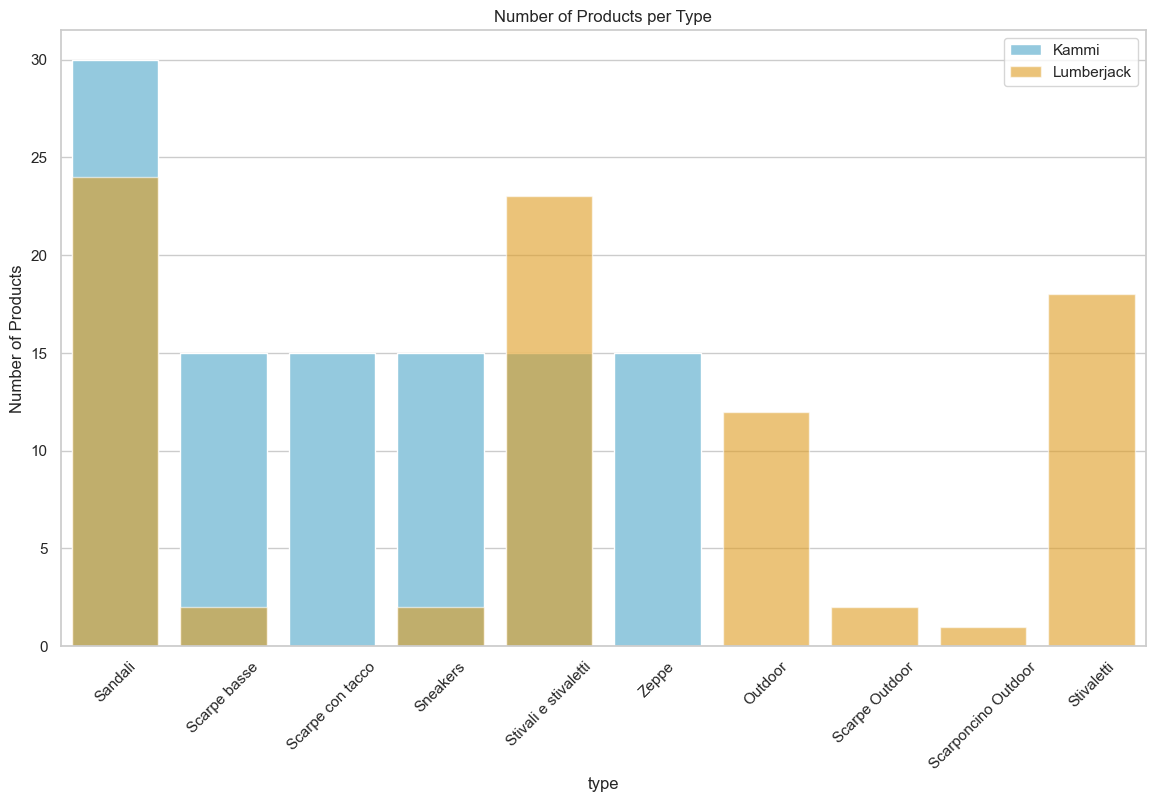

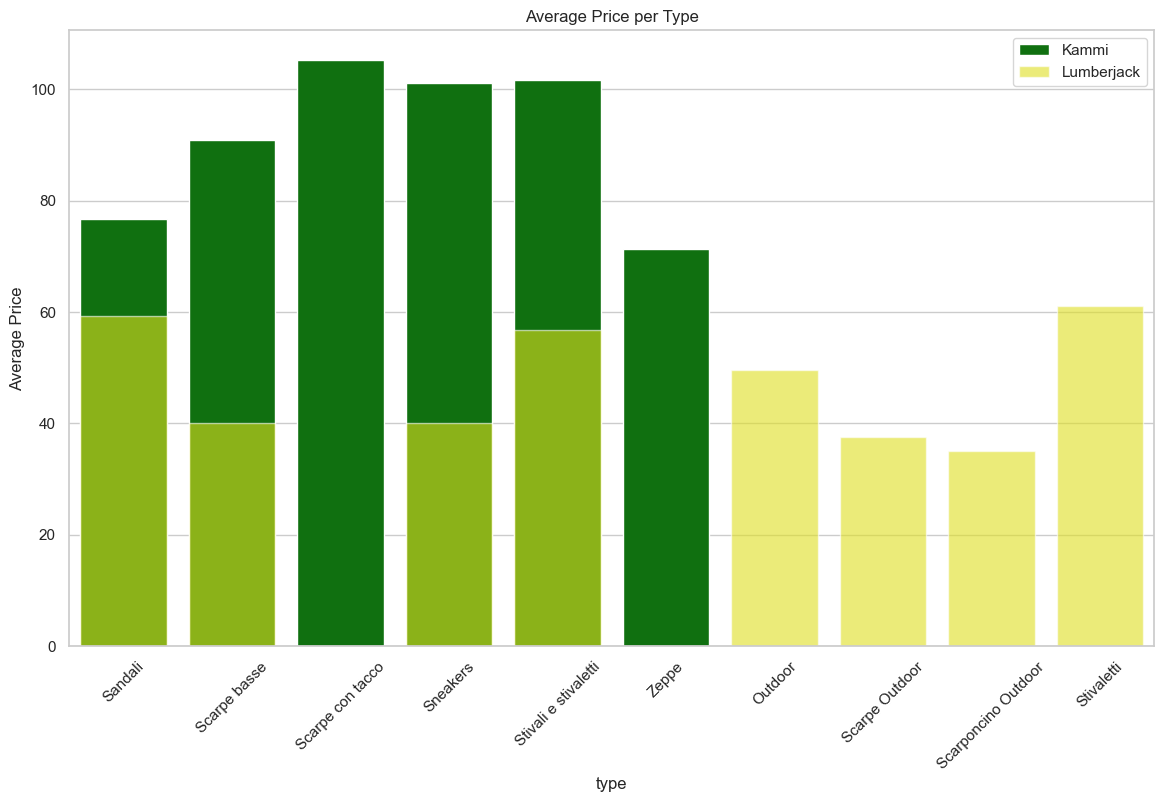

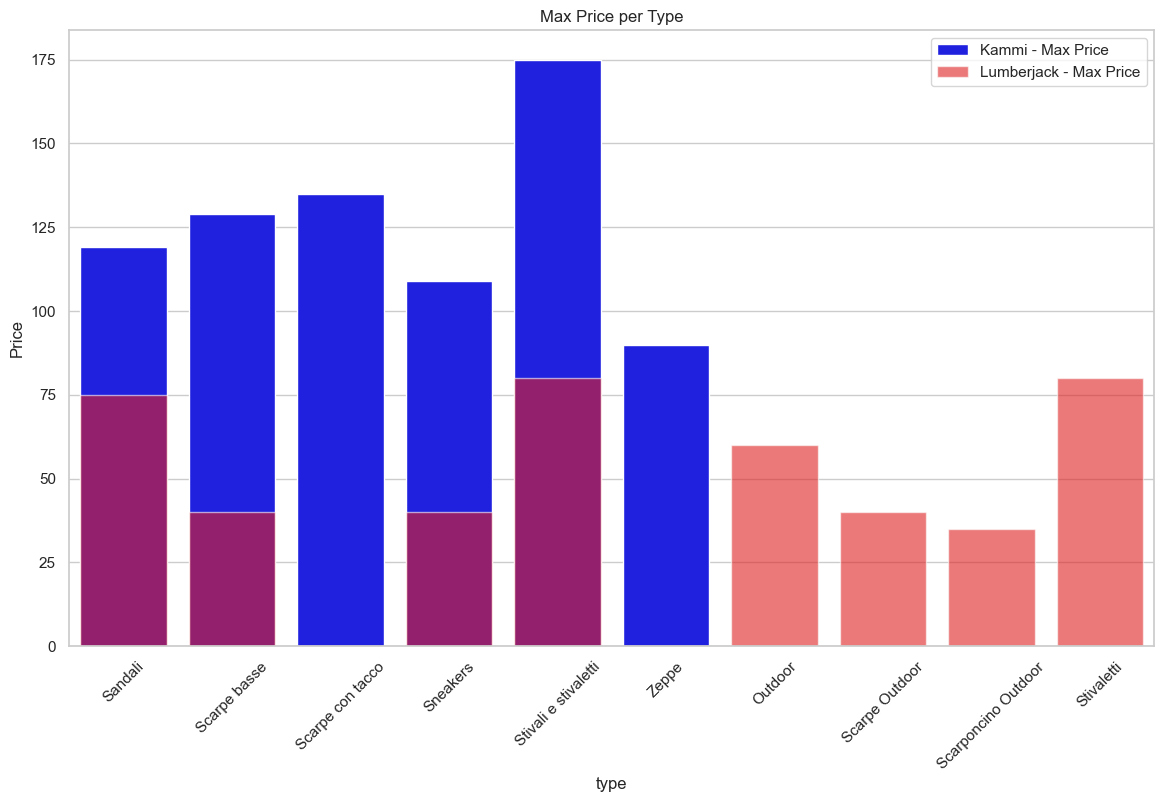

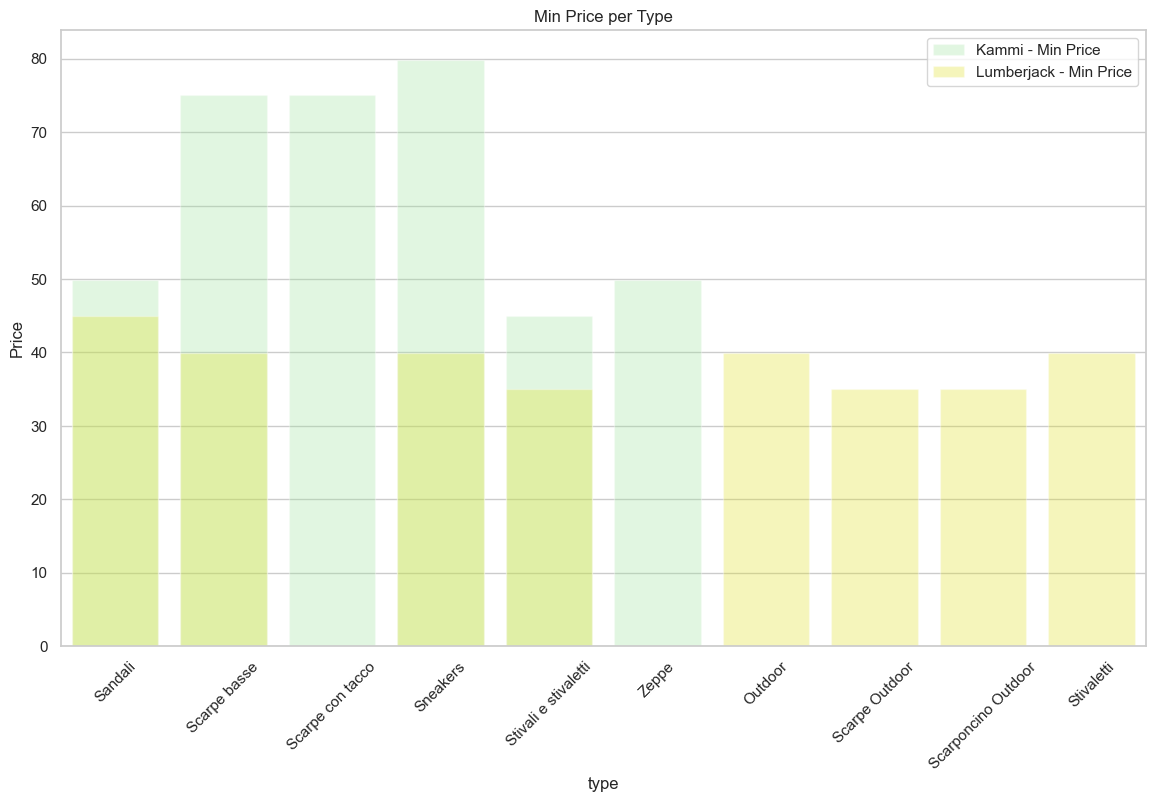

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per il plotting
sns.set(style="whitegrid")

# Grafico del Numero di Prodotti per Tipologia
plt.figure(figsize=(14, 8))
sns.barplot(x='type', y='Number_of_Products_Kammi', data=merged_data, color='skyblue', label='Kammi')
sns.barplot(x='type', y='Number_of_Products_Lumberjack', data=merged_data, color='orange', label='Lumberjack', alpha=0.6)
plt.xticks(rotation=45)
plt.ylabel('Number of Products')
plt.title('Number of Products per Type')
plt.legend()
plt.show()

# Grafico del Prezzo Medio per Tipologia
plt.figure(figsize=(14, 8))
sns.barplot(x='type', y='Avg_Price_Kammi', data=merged_data, color='green', label='Kammi')
sns.barplot(x='type', y='Avg_Price_Lumberjack', data=merged_data, color='yellow', label='Lumberjack', alpha=0.6)
plt.xticks(rotation=45)
plt.ylabel('Average Price')
plt.title('Average Price per Type')
plt.legend()
plt.show()

# Grafico dei Prezzi Minimi e Massimi per Tipologia
plt.figure(figsize=(14, 8))
sns.barplot(x='type', y='Max_Price_Kammi', data=merged_data, color='blue', label='Kammi - Max Price')
sns.barplot(x='type', y='Max_Price_Lumberjack', data=merged_data, color='red', alpha=0.6, label='Lumberjack - Max Price')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.title('Max Price per Type')
plt.legend()
plt.show()

# Grafico dei Prezzi Minimi e Massimi per Tipologia
plt.figure(figsize=(14, 8))
sns.barplot(x='type', y='Min_Price_Kammi', data=merged_data, color='lightgreen', alpha=0.3, label='Kammi - Min Price')
sns.barplot(x='type', y='Min_Price_Lumberjack', data=merged_data, color='yellow', alpha=0.3, label='Lumberjack - Min Price')
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.title('Min Price per Type')
plt.legend()
plt.show()

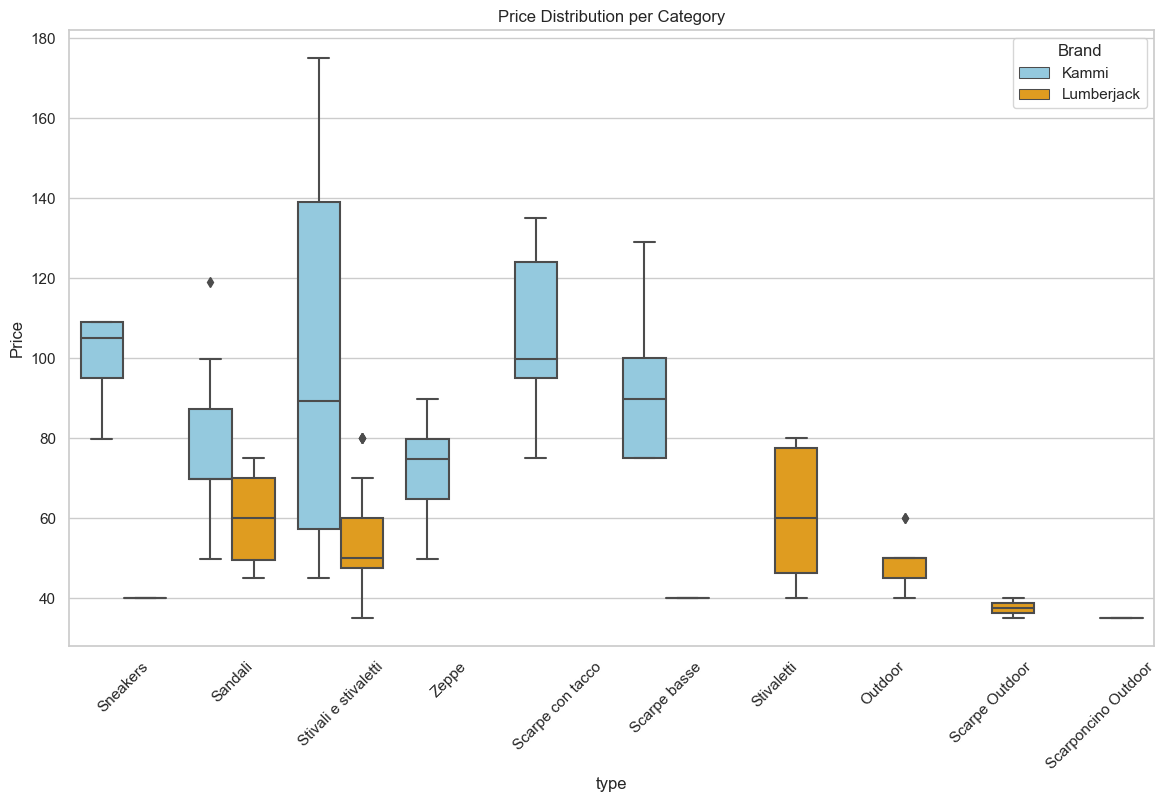

In [26]:
# Preparazione dei dati di Kammi per il merging
kammi_prepared = kammi_df[['type', 'price']].copy()
kammi_prepared['Brand'] = 'Kammi'

# Preparazione dei dati di Lumberjack per il merging
lumberjack_prepared = lumberjack_df_women[['type', 'price']].copy()
lumberjack_prepared['Brand'] = 'Lumberjack'

# Unione dei dati di Kammi e Lumberjack
combined_data = pd.concat([kammi_prepared, lumberjack_prepared], axis=0)

# Creazione di grafici boxplot per la distribuzione dei prezzi per singola categoria
plt.figure(figsize=(14, 8))
sns.boxplot(x='type', y='price', hue='Brand', data=combined_data, palette=['skyblue', 'orange'])
plt.xticks(rotation=45)
plt.ylabel('Price')
plt.title('Price Distribution per Category')
plt.legend(title='Brand')
plt.show()

In [28]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time

# Impostazioni iniziali per Selenium
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service)

# URL della pagina principale del 'store locator' di KAMMI
base_url = "https://www.kammi.it/store-locator.html"

def get_region_click_scripts(base_url):
    driver.get(base_url)
    time.sleep(5)
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    click_scripts = []

    for area in soup.find_all('area'):
        onclick_attr = area.get('onclick')
        if onclick_attr:
            print(f"Onclick attribute found: {onclick_attr}")
            click_scripts.append(onclick_attr)

    return click_scripts

def get_store_details(click_script):
    driver.execute_script(click_script)
    time.sleep(5)
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html.parser')
    store_details = []

    for row in soup.select('table.mappa tr'):
        cells = row.find_all('td')
        if len(cells) >= 3:
            store_name = row.find('a').text.strip()
            city_name = cells[1].text.strip()
            province = cells[2].text.strip()

            store_details.append({
                'store_name': store_name,
                'city_name': city_name,
                'province': province
            })

    return store_details

# Utilizzo delle funzioni
click_scripts = get_region_click_scripts(base_url)
all_stores_details = []
for script in click_scripts:
    stores_details = get_store_details(script)
    all_stores_details.extend(stores_details)
    print(stores_details)

# Chiudere il browser al termine dello scraping
driver.quit()
kimmi_stores = pd.DataFrame(all_stores_details)

Onclick attribute found: return _doClick('Piemonte', this, null)
Onclick attribute found: return _doClick('Liguria', this, null)
Onclick attribute found: return _doClick('Lombardia', this, null)
Onclick attribute found: return _doClick('Veneto', this, null)
Onclick attribute found: return _doClick('Trentino Alto Adige', this, null)
Onclick attribute found: return _doClick('Emilia', this, null)
Onclick attribute found: return _doClick('Toscana', this, null)
Onclick attribute found: return _doClick('Umbria', this, null)
Onclick attribute found: return _doClick('Molise', this, null)
Onclick attribute found: return _doClick('Sicilia', this, null)
Onclick attribute found: return _doClick('Sardegna', this, null)
Onclick attribute found: return _doClick('Abruzzo', this, null)
Onclick attribute found: return _doClick('Marche', this, null)
Onclick attribute found: return _doClick('Friuli-Venezia Giulia', this, null)
Onclick attribute found: return _doClick('Spagna', this, null)
Onclick attribut

[{'store_name': 'COMUNELLO SRL', 'city_name': 'BORGO VALSUGANA', 'province': 'TN'}]
[{'store_name': 'CALZATURE GIORGIO', 'city_name': 'CESENATICO', 'province': 'FC'}, {'store_name': 'DELTASCARPE - SCAGLIARINI S.R.L.', 'city_name': 'ARGENTA', 'province': 'FE'}, {'store_name': "TAITA' - SCAGLIARINI S.R.L.", 'city_name': 'CENTO', 'province': 'FE'}, {'store_name': 'DELTASCARPE - SCAGLIARINI S.R.L.', 'city_name': 'COPPARO', 'province': 'FE'}, {'store_name': "KO'SS SHOES - SCAGLIARINI S.R.L.", 'city_name': 'FERRARA', 'province': 'FE'}, {'store_name': "TAITA' - SCAGLIARINI S.R.L.", 'city_name': 'FERRARA', 'province': 'FE'}, {'store_name': 'KAMMI DI BURANI FLORIANA', 'city_name': 'CARPI', 'province': 'MO'}, {'store_name': 'CAMMINANDO SRL', 'city_name': 'PIACENZA', 'province': 'PC'}, {'store_name': 'AL RISPARMIO CALZATURE - MCR srl', 'city_name': 'PARMA', 'province': 'PR'}, {'store_name': 'STEP BY STEP SNC', 'city_name': 'CASTELBOLOGNESE', 'province': 'RA'}, {'store_name': 'STEP BY STEP SNC', '

In [29]:
kammi_stores = kimmi_stores[['store_name', 'province']]

# Visualizzazione del DataFrame risultante
kammi_stores

,store_name,province
0,DOTTA CALZ. S.n.c.,AL
1,F.LLI BRUNO S.n.c.,AL
2,F.LLI BRUNO S.n.c.,AL
3,KAMMI CALZATURE - NOSENGO SBA,AL
4,NOSENGO CALZATURE - SBA,AL
...,...,...
132,BUFFALINI SCHOENEN,BE
133,ALTALENA S.A.,BELLINZONA
134,ALTALENA S.A.,LUGANO
135,ALTALENA S.A.,LUGANO


In [30]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# URL of the website to scrape
url = "https://negozi.justshopping.it/negozi/lumberjack/"

# Function to extract city names using Selenium
def extract_city_names_with_selenium(url):
    # Initialize the Selenium Chrome driver
    driver = webdriver.Chrome()

    # Open the webpage
    driver.get(url)

    # Wait for the page to load and for the list items to be present
    WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CSS_SELECTOR, "li.page_item a"))
    )

    # Find all anchor tags within list items that contain city-specific Lumberjack store pages
    city_elements = driver.find_elements(By.CSS_SELECTOR, "li.page_item a")

    city_names = []
    # Extract the city names
    for element in city_elements:
        city_name = element.text.replace('Lumberjack ', '').strip()
        city_names.append(city_name)

    # Close the browser
    driver.quit()

    return city_names

# Use the function to extract city names
city_names = extract_city_names_with_selenium(url)

# Create a DataFrame
store_lumberjack = pd.DataFrame({'marchio': ['Lumberjack'] * len(city_names), 'shop': city_names})


In [31]:
store_lumberjack_cleaned = store_lumberjack.drop([0, 1])

# Reset dell'indice dopo la rimozione delle righe
store_lumberjack_cleaned.reset_index(drop=True, inplace=True)

# Normalizzazione dei tipi di scarpe in kammi_df
store_lumberjack_cleaned["shop"] = store_lumberjack_cleaned["shop"].replace({
    'Agrigento': 'AG',
    'Bari': 'BA',
    'Brescia': 'BS',
    'Catania': 'CT',
    'Crotone': 'KR',
    'Cuneo': 'CN',
    'Ferrara': 'FE',
    'Genova': 'GE',
    'Mantova': 'MN',
    'Milano': 'MI',
    'Palermo': 'PA',
    'Ragusa': 'RG',
    'Reggio Calabria': 'RC',
    'Roma': 'RM',
    'Siena': 'SI',
    'Siracusa': 'SR',
    'Torino': 'TO',
    'Trento': 'TN'
})


# Verifica della normalizzazione
store_lumberjack_cleaned_normalized = store_lumberjack_cleaned["shop"].unique()


store_lumberjack_cleaned = store_lumberjack_cleaned.rename(columns={'shop': 'province'})

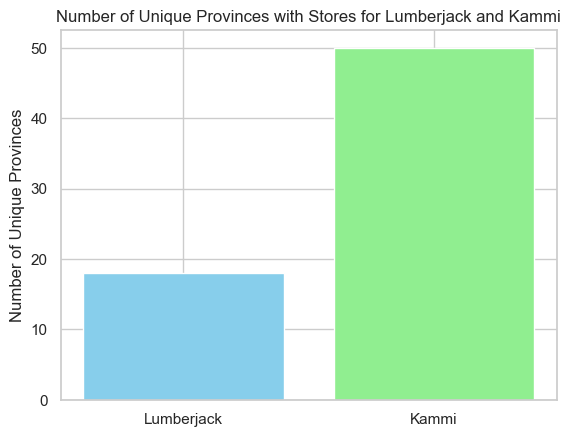

In [32]:
# Calculating the number of unique provinces for each brand
lumberjack_unique_provinces = store_lumberjack_cleaned['province'].nunique()
kammi_unique_provinces = kammi_stores['province'].nunique()

# Preparing data for the plot
brands = ['Lumberjack', 'Kammi']
unique_provinces_counts = [lumberjack_unique_provinces, kammi_unique_provinces]

# Plotting
fig, ax = plt.subplots()
ax.bar(brands, unique_provinces_counts, color=['skyblue', 'lightgreen'])
ax.set_title('Number of Unique Provinces with Stores for Lumberjack and Kammi')
ax.set_ylabel('Number of Unique Provinces')
plt.show()

Andrea

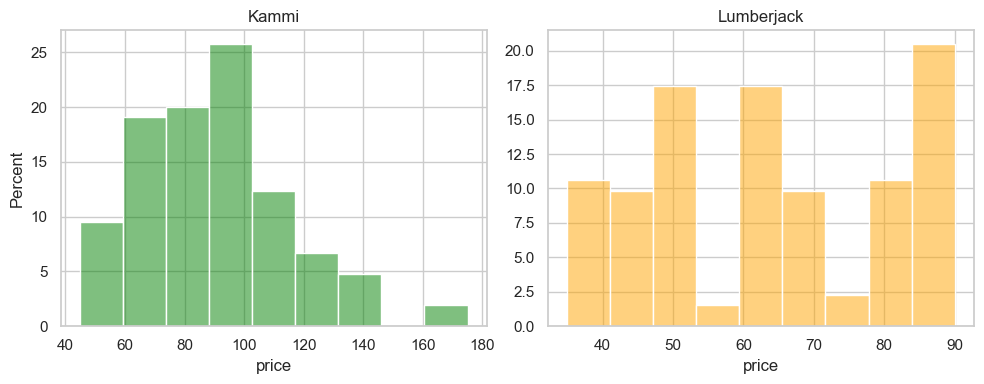

In [33]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,4))

sns.histplot(data=kammi_df,x="price", stat="percent", color = "green", alpha=0.5, ax=axes[0])

axes[0].set_title('Kammi')

sns.histplot(data=lumberjack_df,x="price", stat="percent", color = "orange", alpha=0.5)

axes[1].set_title('Lumberjack')
axes[1].set_ylabel('')

plt.tight_layout()

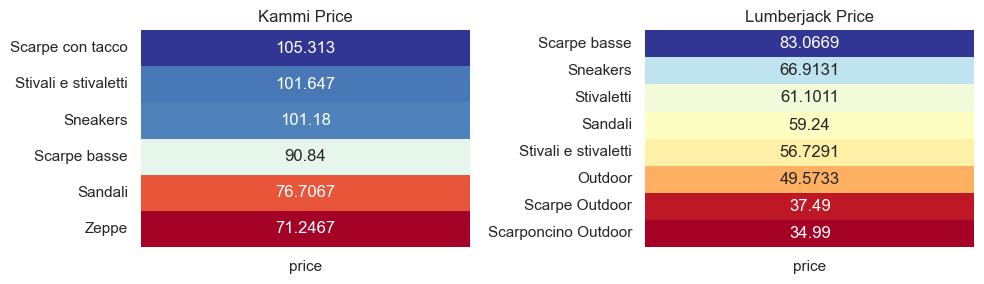

In [39]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(10,3))

(sns.heatmap(data=kammi_df.groupby("type")[["price"]].mean().sort_values(by="price", ascending=False)
             , annot=True, cmap='RdYlBu', fmt='g', cbar= False, ax=axes[0])
)

axes[0].set_title('Kammi Price')
axes[0].set_ylabel('')

(sns.heatmap(data=lumberjack_df.groupby("type")[["price"]].mean().sort_values(by="price", ascending=False)
             , annot=True, cmap='RdYlBu', fmt='g', cbar= False, ax=axes[1])
)

axes[1].set_title('Lumberjack Price')
axes[1].set_ylabel('')

plt.tight_layout()

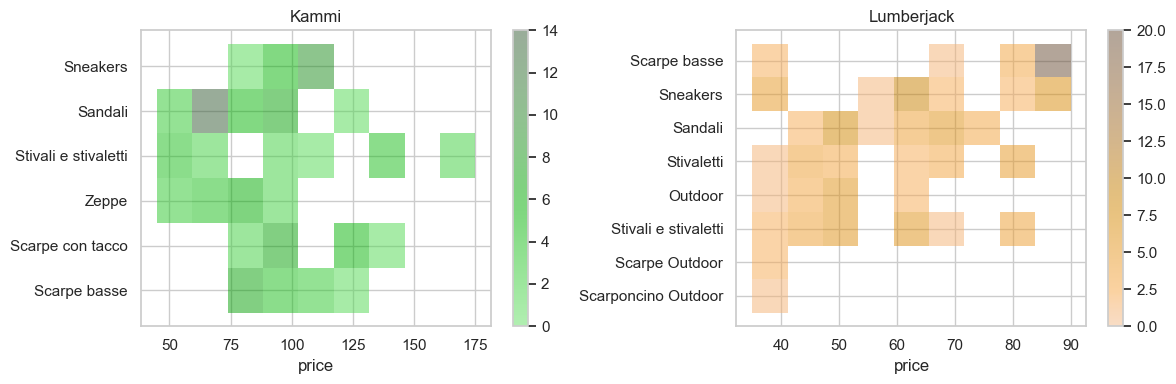

In [43]:
# Affianco le tiplogie di prezzo

fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

sns.histplot(data=kammi_df,x="price", y="type", color = "green", alpha=0.5, ax=axes[0], cbar=True)

axes[0].set_title('Kammi')
axes[0].set_ylabel('')

sns.histplot(data=lumberjack_df,x="price", y="type", color = "orange", alpha=0.5, ax=axes[1], cbar=True)

axes[1].set_title('Lumberjack')
axes[1].set_ylabel('')

plt.tight_layout()